In [ ]:
import numpy as np
import pandas as pd
import datetime as dt
import os
import gymnasium as gym
from gymnasium import spaces
from scipy.special import softmax
import matplotlib.pyplot as plt
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from typing import Dict, List, Tuple, Optional
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# DATA_DIR must be appended before the filename
DATA_DIR = "/Users/newuser/Projects/robust_algo_trader/data/gen_synthetic_data/preprocessed_data"

In [ ]:
# save dir should add the current date and time
SAVE_DIR = f"./models/model_{dt.datetime.now().strftime('%Y%m%d_%H%M%S')}"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
class PortfolioEnv(gym.Env):
    metadata = {'render_modes': ['human']}
    
    def __init__(self, stock_data_list: List[pd.DataFrame], episode_length: int = 12, temperature: float = 0.3, window_size: int = 252):
        super(PortfolioEnv, self).__init__()
        
        self.stocks = {f'stock_{i}': df for i, df in enumerate(stock_data_list)}
        self.n_stocks = len(self.stocks)
        self.episode_length = episode_length
        self.temperature = temperature
        self.window_size = window_size  # Window size for feature scaling (252 days = 1 year)
        
        # Use raw features instead of pre-scaled ones
        self.features = [
            'Close', 'MA5', 'MA20', 'MA50', 'MA200',
            'RSI', 'BB_width', 'ATR', 'Return_1W',
            'Return_1M', 'Return_3M', 'CurrentDrawdown',
            'MaxDrawdown_252d', 'Sharpe_20d', 'Sharpe_60d'
        ]
        
        obs_dim = len(self.features) * self.n_stocks
        self.observation_space = spaces.Box(
            low=-1, high=1,
            shape=(obs_dim,), 
            dtype=np.float32
        )
  
        self.action_space = spaces.Box(
            low=-1, high=1,
            shape=(self.n_stocks,),
            dtype=np.float32
        )
        
        self.reset()
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        
        data_length = len(next(iter(self.stocks.values())))
        max_start_idx = data_length - self.episode_length * 30 - 20
        
        # No minimum start index, as data is assumed to be clean
        self.current_step = np.random.randint(0, max_start_idx)
        self.current_month = 0
        
        self.monthly_returns = []
        self.portfolio_value = 100.0
        self.previous_allocation = np.zeros(self.n_stocks)
        
        observation = self._get_observation()
        info = {}
        
        return observation, info
    
    
    def _get_observation(self):
        observation = []
        for stock_name, stock_data in self.stocks.items():
            # Get window for scaling (including current step)
            window_start = max(0, self.current_step - self.window_size + 1)  # +1 to make room for current step
            window_end = self.current_step + 1  # +1 because slice is exclusive of end index
            window_data = stock_data.iloc[window_start:window_end]
            
            # Scale all features for the entire window
            scaled_features = []
            for feature in self.features:
                scaler = MinMaxScaler(feature_range=(-1, 1))
                feature_values = window_data[feature].values.reshape(-1, 1)
                scaled_window = scaler.fit_transform(feature_values)
                
                # Get the scaled value for the current step (last value in the window)
                scaled_val = scaled_window[-1][0]  # Last row, first column
                scaled_features.append(scaled_val)
            observation.extend(scaled_features)
        return np.array(observation, dtype=np.float32)
    
    # Then update the _convert_to_allocation method:
    def _convert_to_allocation(self, action_weights):
        # No need to rescale the action_weights from [-1, 1]
        print("Action Weights")
        print(action_weights)
        # Softmax works fine with negative values
        # Apply softmax with temperature scaling
        raw_allocation = softmax(np.array(action_weights) / self.temperature)
        
        # Calculate initial percent allocations
        percentages = raw_allocation * 100
        
        # Apply discretization constraint (0%, 10%, 20%, 30%)
        # First, find the nearest valid allocation (multiples of 10%)
        allocations = np.round(percentages / 10) * 10
        allocations = np.clip(allocations, 0, 30)
        
        # Determine adjustment needed to sum to 100%
        total_allocation = np.sum(allocations)
        adjustment_needed = 100 - total_allocation
        
        if adjustment_needed != 0:
            # Calculate how close each stock was to the next discretization level
            distance_to_next = np.zeros_like(allocations)
            
            for i in range(len(allocations)):
                if adjustment_needed > 0 and allocations[i] < 30:
                    # If we need to add: how close to rounding up?
                    distance_to_next[i] = 10 - (percentages[i] % 10)
                elif adjustment_needed < 0 and allocations[i] > 0:
                    # If we need to subtract: how close to rounding down?
                    distance_to_next[i] = percentages[i] % 10
                else:
                    # Can't adjust this stock
                    distance_to_next[i] = float('inf')
            
            # Prioritize adjustments for stocks closest to the next level
            num_adjustments = int(abs(adjustment_needed) // 10)
            
            if num_adjustments > 0:
                adjustment_indices = np.argsort(distance_to_next)[:num_adjustments]
                
                for idx in adjustment_indices:
                    if adjustment_needed > 0 and allocations[idx] < 30:
                        allocations[idx] += 10
                        adjustment_needed -= 10
                    elif adjustment_needed < 0 and allocations[idx] > 0:
                        allocations[idx] -= 10
                        adjustment_needed += 10
        # print the step number and the stock names with their allocations
        # print(f"Step {self.current_step}")
        # print the stock names and their allocations
        # for stock_name, allocation in zip(self.stocks.keys(), allocations):
        #     print(f"{stock_name}: {allocation}%")
        return allocations
    
    
    def step(self, action):
        allocation = self._convert_to_allocation(action)
        self.previous_allocation = allocation.copy()
        portfolio_return, stock_returns = self._calculate_monthly_performance(allocation)
        self.portfolio_value *= (1 + portfolio_return)
        
        # Get raw metrics (not scaled) for reward calculation
        sharpe = self._calculate_portfolio_metric('Sharpe_20d', allocation)
        max_drawdown = self._calculate_portfolio_metric('MaxDrawdown_252d', allocation)
        reward = self._calculate_reward(portfolio_return, sharpe, max_drawdown)
        self.monthly_returns.append(portfolio_return)
        
        info = {
            'portfolio_return': portfolio_return,
            'portfolio_value': self.portfolio_value,
            'sharpe': sharpe,
            'max_drawdown': max_drawdown,
            'allocation': allocation.copy(),
            'stock_returns': stock_returns
        }
        
        self.current_step += 30
        self.current_month += 1
        
        terminated = (self.current_month >= self.episode_length)
        truncated = False
        observation = self._get_observation()
        
        return observation, reward, terminated, truncated, info
    
    def _calculate_monthly_performance(self, allocation):
        current_prices = np.array([
            self.stocks[f'stock_{i}'].iloc[self.current_step]['Close'] 
            for i in range(self.n_stocks)
        ])
        
        next_step = min(self.current_step + 30, len(next(iter(self.stocks.values()))) - 1)
        next_prices = np.array([
            self.stocks[f'stock_{i}'].iloc[next_step]['Close'] 
            for i in range(self.n_stocks)
        ])
        
        stock_returns = (next_prices - current_prices) / current_prices
        portfolio_return = np.sum((allocation / 100) * stock_returns)
        
        return portfolio_return, stock_returns
    
    def _calculate_portfolio_metric(self, metric_name, allocation):
        if not all(metric_name in stock_df.columns for stock_df in self.stocks.values()):
            return 0.0
        
        metric_values = np.array([
            self.stocks[f'stock_{i}'].iloc[self.current_step][metric_name] 
            for i in range(self.n_stocks)
        ])
        return np.sum((allocation / 100) * metric_values)
    
    def _calculate_reward(self, portfolio_return, sharpe, max_drawdown):
        # Get the average return across all stocks as a benchmark for the current month
        # The Return_1M metric is the return over the past month, not the future month
        benchmark_returns = np.mean([
            self.stocks[f'stock_{i}'].iloc[self.current_step].get('Return_1M', 0)
            for i in range(self.n_stocks)
        ])
        
        # Calculate excess return over benchmark
        excess_return = portfolio_return - max(0, benchmark_returns * 0.01)  # Scaled benchmark
        
        # Base reward from excess return (higher weight for outperformance)
        base_reward = excess_return * 100
        
        # Risk-adjusted components
        sharpe_component = sharpe * 1.0  # Increased weight on Sharpe
        drawdown_component = max_drawdown * -1.5  # Slightly reduced drawdown penalty
        
        # Apply higher penalty for large drawdowns but lower for small ones
        if max_drawdown < -0.1:  # Only penalize significant drawdowns
            drawdown_component *= 1.5
        
        # Combine components
        reward = base_reward + sharpe_component + drawdown_component
        
        return reward
    
    def render(self, mode='human'):
        print(f"Month {self.current_month}")
        print(f"Allocation: {self.previous_allocation}")
        if self.monthly_returns:
            print(f"Last month return: {self.monthly_returns[-1]:.4f}")
            print(f"Portfolio value: {self.portfolio_value:.2f}")
    
    def close(self):
        pass

# Some helper functions to train and evaluate the model
def train_model(stock_data_list, total_timesteps=200_000):
    print("Creating environment...")
    env = PortfolioEnv(stock_data_list)
    check_env(env)
    
    print("Initializing PPO agent...")
    model = PPO(
        "MlpPolicy", 
        env,
        tensorboard_log="./portfolio_env_logs",
        device="mps",
        verbose=1,
        # learning_rate=3e-4,
        # gamma=0.99,
        # n_steps=2048,
        # ent_coef=0.01,
        # vf_coef=0.5,
        # max_grad_norm=0.5,
        # policy_kwargs={'net_arch': [256, 128, dict(vf=[64], pi=[64])]}
    )
    
    checkpoint_callback = CheckpointCallback(
        save_freq=10_000,
        save_path=SAVE_DIR,
        name_prefix="ppo",
        save_replay_buffer=False,
        save_vecnormalize=False,
    )
    
    print(f"Training for {total_timesteps} timesteps...")
    model.learn(
        total_timesteps=total_timesteps,
        callback=checkpoint_callback,
        progress_bar=True
    )
    
    final_model_path = os.path.join(SAVE_DIR, "ppo_portfolio_final")
    model.save(final_model_path)
    print(f"Final model saved to {final_model_path}")
    return model


def evaluate_model(stock_data_list, trained_model, n_episodes=10):
    print(f"Evaluating agent over {n_episodes} episodes...")
    eval_env = Monitor(PortfolioEnv(stock_data_list))
    # eval_env = PortfolioEnv(stock_data_list)
    mean_reward, std_reward = evaluate_policy(
        trained_model, 
        eval_env, 
        deterministic=True
    )
    print(f"Mean reward: {mean_reward:.4f} ± {std_reward:.4f}")
    results = detailed_evaluation(trained_model, eval_env)
    
    print("\nPerformance Summary:")
    print(f"Average Monthly Return: {results['mean_return']:.4f}")
    print(f"Average Sharpe Ratio: {results['mean_sharpe']:.4f}")
    print(f"Average Max Drawdown: {results['mean_drawdown']:.4f}")
    print(f"Average Portfolio Allocation: {results['avg_allocation']}")
    print(f"Final Average Portfolio Value: ${results['mean_final_value']:.2f}")
    return results

def detailed_evaluation(trained_model, eval_env, n_episodes=10):
    all_allocations = []
    all_returns = []
    all_sharpes = []
    all_drawdowns = []
    monthly_allocations = []
    final_values = []
    
    for episode in range(n_episodes):
        obs, info = eval_env.reset()
        episode_allocations = []
        episode_returns = []
        episode_sharpes = []
        episode_drawdowns = []
        done = False
        
        while not done:
            action, _ = trained_model.predict(obs, deterministic=True)
            obs, reward, terminated, truncated, info = eval_env.step(action)
            done = terminated or truncated
            episode_allocations.append(info['allocation'])
            episode_returns.append(info['portfolio_return'])
            episode_sharpes.append(info['sharpe'])
            episode_drawdowns.append(info['max_drawdown'])
            
            if done:
                final_values.append(info['portfolio_value'])
        
        all_allocations.append(episode_allocations)
        monthly_allocations.extend(episode_allocations)
        all_returns.append(np.mean(episode_returns))
        all_sharpes.append(np.mean(episode_sharpes))
        all_drawdowns.append(np.mean(episode_drawdowns))
        
        print(f"Episode {episode+1}: Return = {np.mean(episode_returns):.4f}, Final Value = ${final_values[-1]:.2f}")
    
    avg_allocation = np.mean(monthly_allocations, axis=0)
    
    create_visualizations(
        avg_allocation, 
        all_returns, 
        all_sharpes, 
        all_drawdowns,
        final_values
    )
    
    return {
        'mean_return': np.mean(all_returns),
        'mean_sharpe': np.mean(all_sharpes),
        'mean_drawdown': np.mean(all_drawdowns),
        'mean_final_value': np.mean(final_values),
        'avg_allocation': avg_allocation
    }

def create_visualizations(avg_allocation, returns, sharpes, drawdowns, final_values):
    os.makedirs('results', exist_ok=True)
    
    plt.figure(figsize=(12, 6))
    bars = plt.bar(range(len(avg_allocation)), avg_allocation)
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 1,
                 f'{height:.1f}%',
                 ha='center', va='bottom', rotation=0)
        
    # create results dir if it doesn't exist
    results_dir = f'{SAVE_DIR}/results/'
    if not os.path.exists(results_dir):
        os.makedirs(results_dir)
    
    
    plt.xlabel('Stock')
    plt.ylabel('Average Allocation (%)')
    plt.title('Average Portfolio Allocation')
    plt.xticks(range(len(avg_allocation)), [f'Stock {i}' for i in range(len(avg_allocation))])
    plt.ylim(0, max(avg_allocation) * 1.2)
    plt.savefig(f'{SAVE_DIR}/results/portfolio_allocation.png')
    
    plt.figure(figsize=(10, 6))
    plt.hist(returns, bins=10, alpha=0.7)
    plt.axvline(np.mean(returns), color='r', linestyle='dashed', linewidth=2)
    plt.text(np.mean(returns)*1.1, plt.ylim()[1]*0.9, f'Mean: {np.mean(returns):.4f}')
    plt.xlabel('Average Monthly Return')
    plt.ylabel('Frequency')
    plt.title('Distribution of Average Monthly Returns')
    plt.savefig(f'{SAVE_DIR}/results/returns_distribution.png')
    
    plt.figure(figsize=(10, 6))
    plt.hist(final_values, bins=10, alpha=0.7)
    plt.axvline(np.mean(final_values), color='r', linestyle='dashed', linewidth=2)
    plt.text(np.mean(final_values)*1.02, plt.ylim()[1]*0.9, f'Mean: ${np.mean(final_values):.2f}')
    plt.xlabel('Final Portfolio Value ($)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Final Portfolio Values (12-month episodes)')
    plt.savefig(f'{SAVE_DIR}/results/portfolio_values.png')
    
    plt.figure(figsize=(12, 6))
    metrics = ['Return (%)', 'Sharpe', 'Drawdown (%)']
    values = [np.mean(returns)*100, np.mean(sharpes), np.mean(drawdowns)*100]
    colors = ['green', 'blue', 'red']
    
    bars = plt.bar(metrics, values, color=colors)
    plt.title('Average Performance Metrics')
    
    for bar in bars:
        height = bar.get_height()
        sign = "+" if height > 0 else ""
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.1 if height > 0 else height - 0.6,
                 f'{sign}{height:.2f}',
                 ha='center', va='bottom' if height > 0 else 'top')
    
    plt.savefig(f'{SAVE_DIR}/results/performance_metrics.png')
    print("Visualizations saved to 'results' directory")

In [ ]:
def get_stock_data_list(instrument_list):
    stock_data_list = []
    for instrument in instrument_list:
        file_path = f"{DATA_DIR}/preprocessed_{instrument}.csv"
        df = pd.read_csv(file_path)
        
        if 'Date' in df.columns:
            df['Date'] = pd.to_datetime(df['Date'])
            df = df.sort_values('Date')
        
        stock_data_list.append(df)
        print(f"Loaded {instrument} with {len(df)} data points")
    
    return stock_data_list

## TRAINING THE RL AGENT

In [ ]:

# Load stock data from directory
instrument_list = ["BIT", "CAQD", "CDUV", "CDZ", "CMA", "CQFV", "DEI", "DNW", "DPJE", "EZIG"] 
stock_data_list = get_stock_data_list(instrument_list)
print("Training model...")

trained_model = train_model(stock_data_list)
print("Training complete!")

## EVALUATING THE RL AGENT

In [ ]:
# load the trained model
trained_model = PPO.load(f"/Users/newuser/Projects/robust_algo_trader/models/model_20250305_164902/ppo_portfolio_final")
instrument_list = ["FLTF", "FLVU", "HCJ", "HQAO", "HYNC", "IPJU", "JDS", "JOSU", "KISO", "KTTK"] 
stock_data_list = get_stock_data_list(instrument_list)
print("Evaluating model...")

evaluate_model(stock_data_list, trained_model)
print("Evaluation complete!")

Generated stock with Sharpe: 0.94, Annual return: 20.24%
Generated stock with Sharpe: 0.75, Annual return: 15.55%
Generated stock with Sharpe: 0.99, Annual return: 12.42%
Generated stock with Sharpe: 1.85, Annual return: 17.16%
Generated stock with Sharpe: 0.88, Annual return: 17.45%
Generated stock with Sharpe: 0.98, Annual return: 21.76%
Generated stock with Sharpe: 1.13, Annual return: 17.78%
Generated stock with Sharpe: 1.43, Annual return: 22.95%
Generated stock with Sharpe: 1.27, Annual return: 26.28%
Generated stock with Sharpe: 0.65, Annual return: 12.09%
Generated 10 stock datasets

Stock 1:
Date range: 2010-12-21 00:00:00 to 2019-08-29 00:00:00
Annualized return: 20.24%
Sharpe ratio: 0.94
Maximum drawdown: -28.98%
Plot saved to 'synthetic_stock_1.png'

Stock 2:
Date range: 2010-12-21 00:00:00 to 2019-08-29 00:00:00
Annualized return: 15.55%
Sharpe ratio: 0.75
Maximum drawdown: -28.37%
Plot saved to 'synthetic_stock_2.png'

Stock 3:
Date range: 2010-12-21 00:00:00 to 2019-08-2

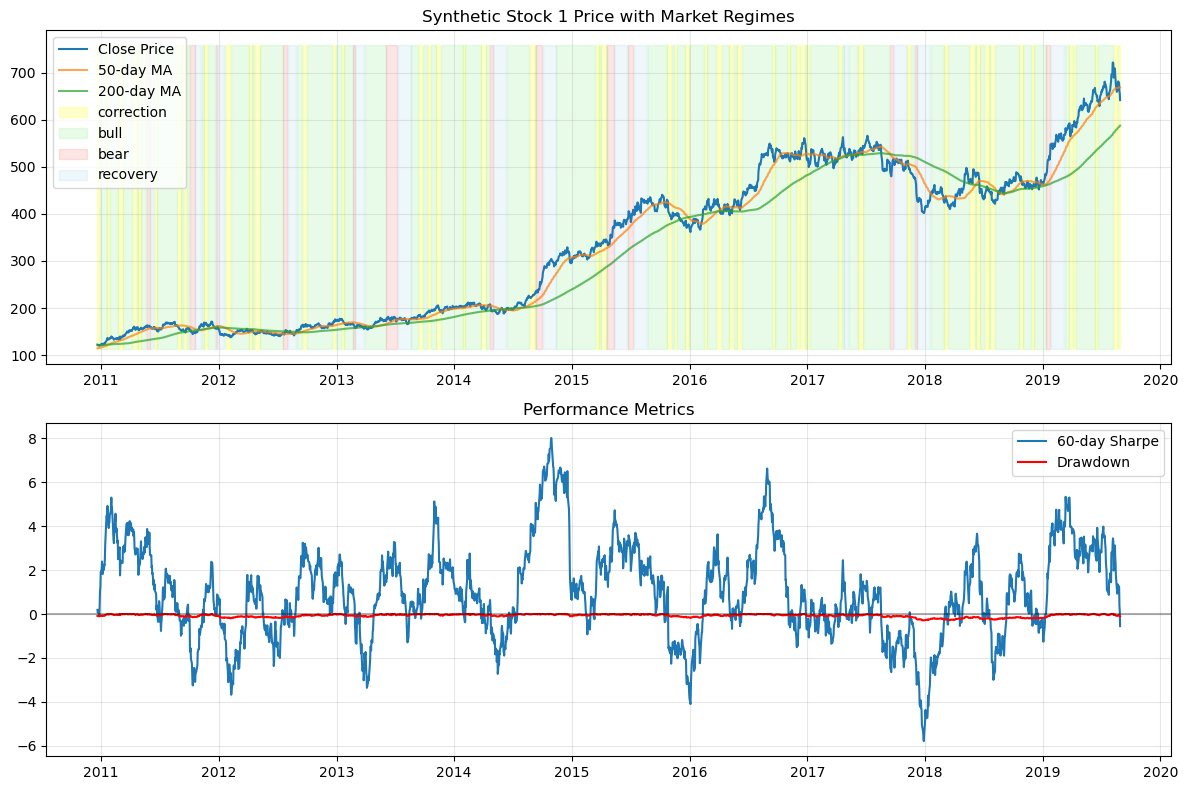

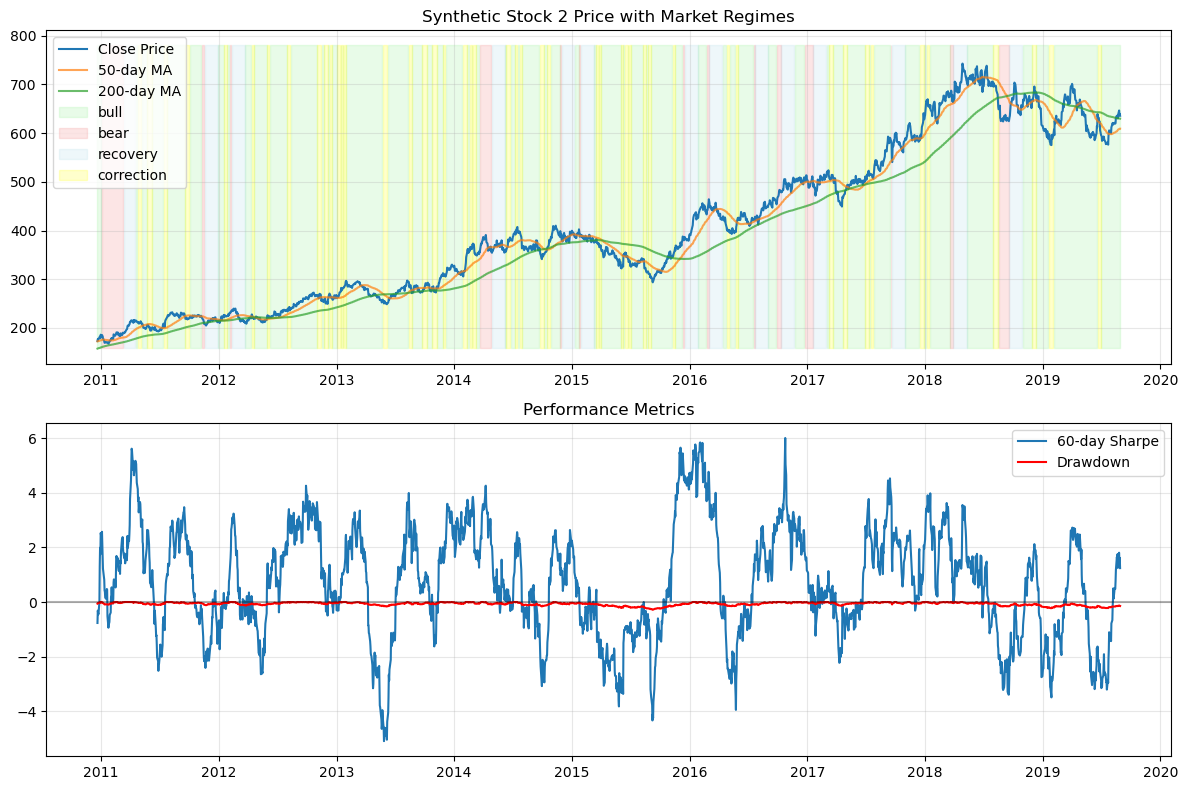

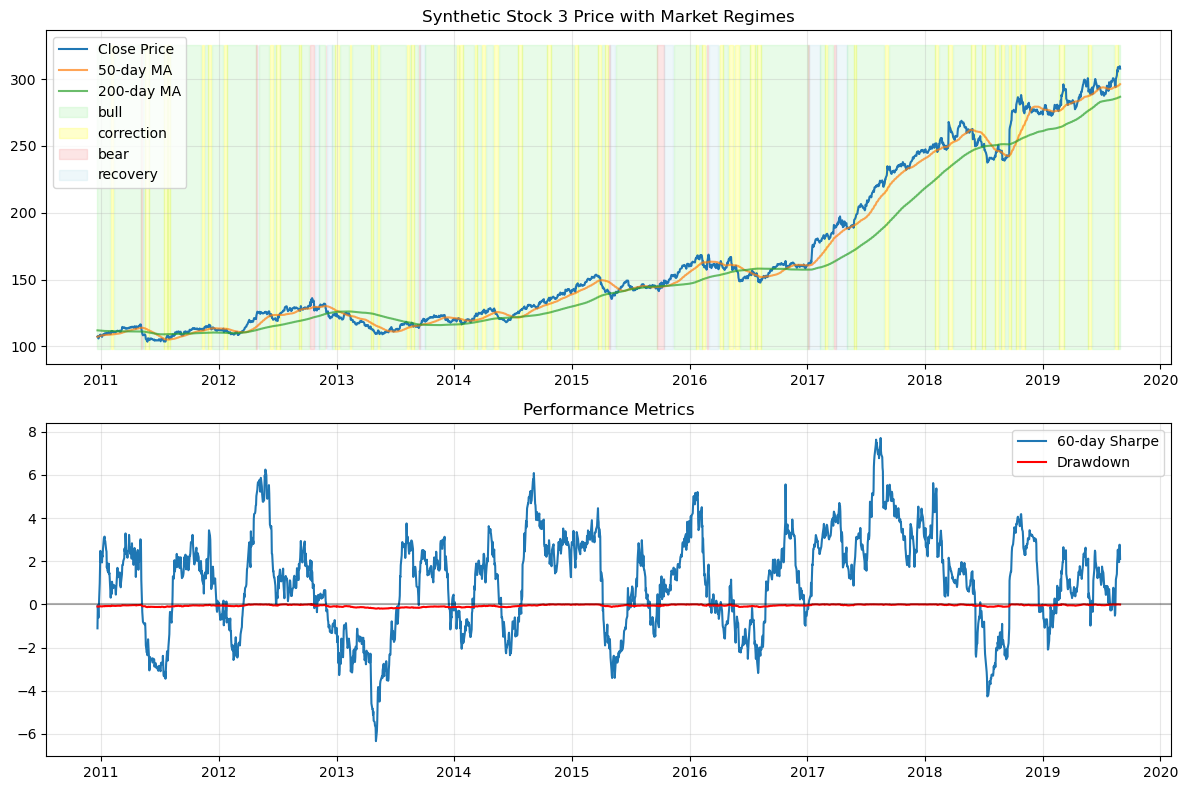

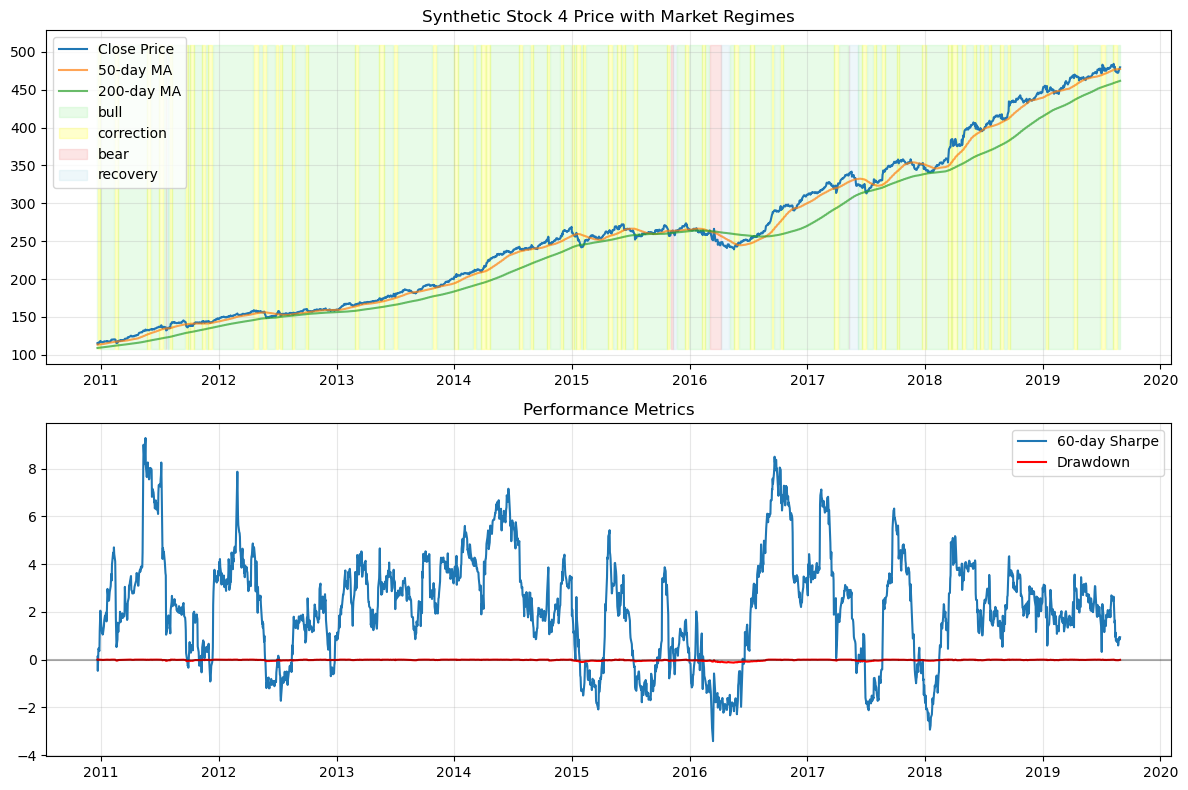

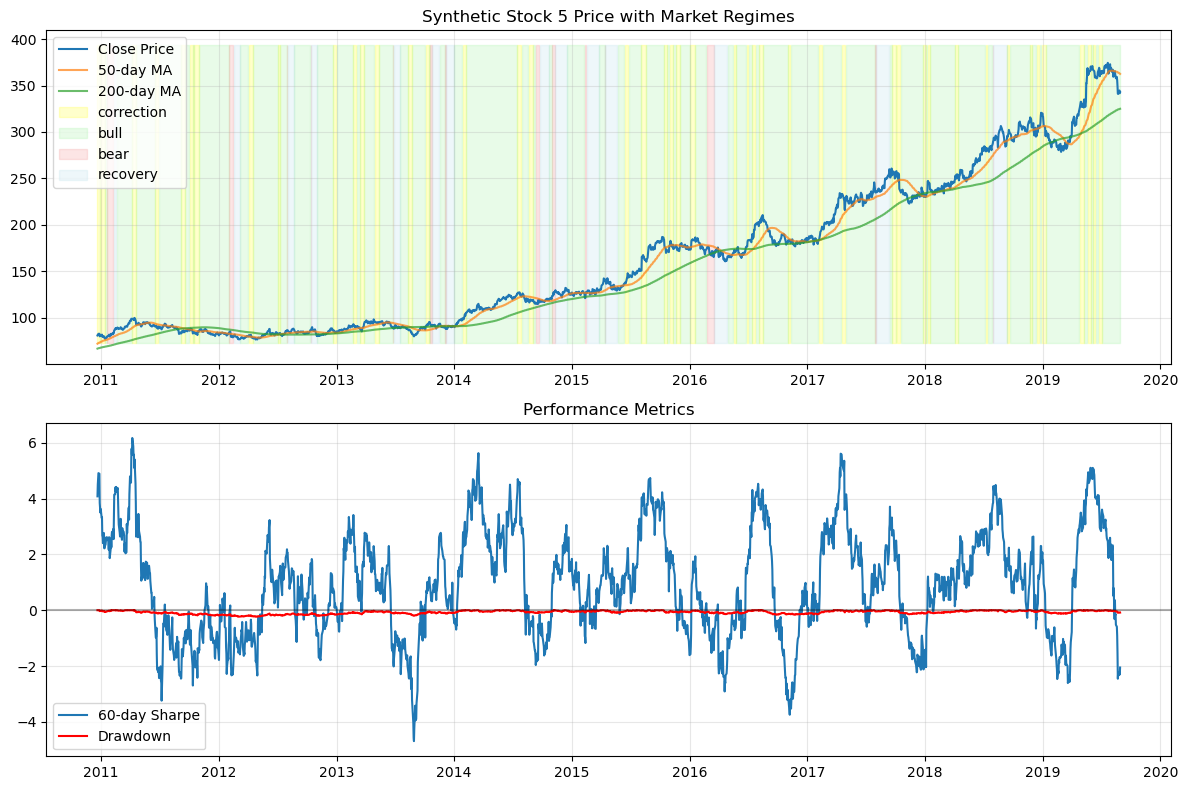

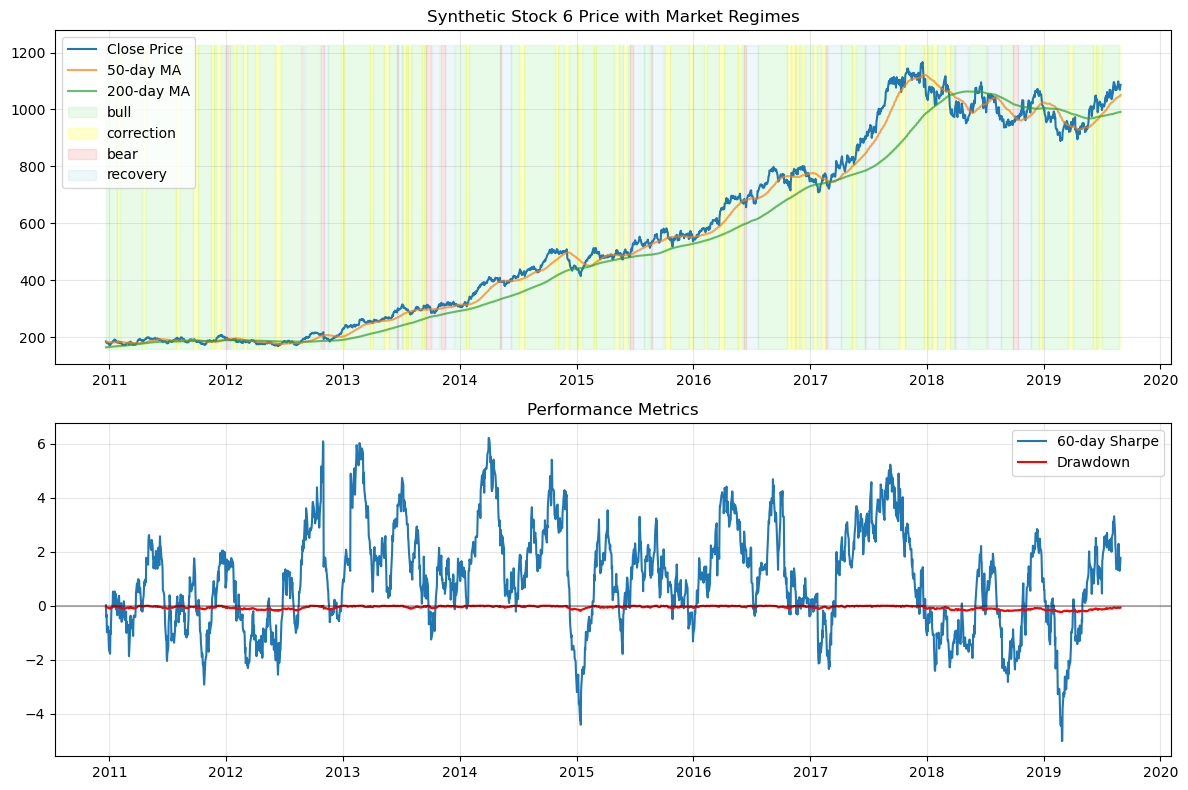

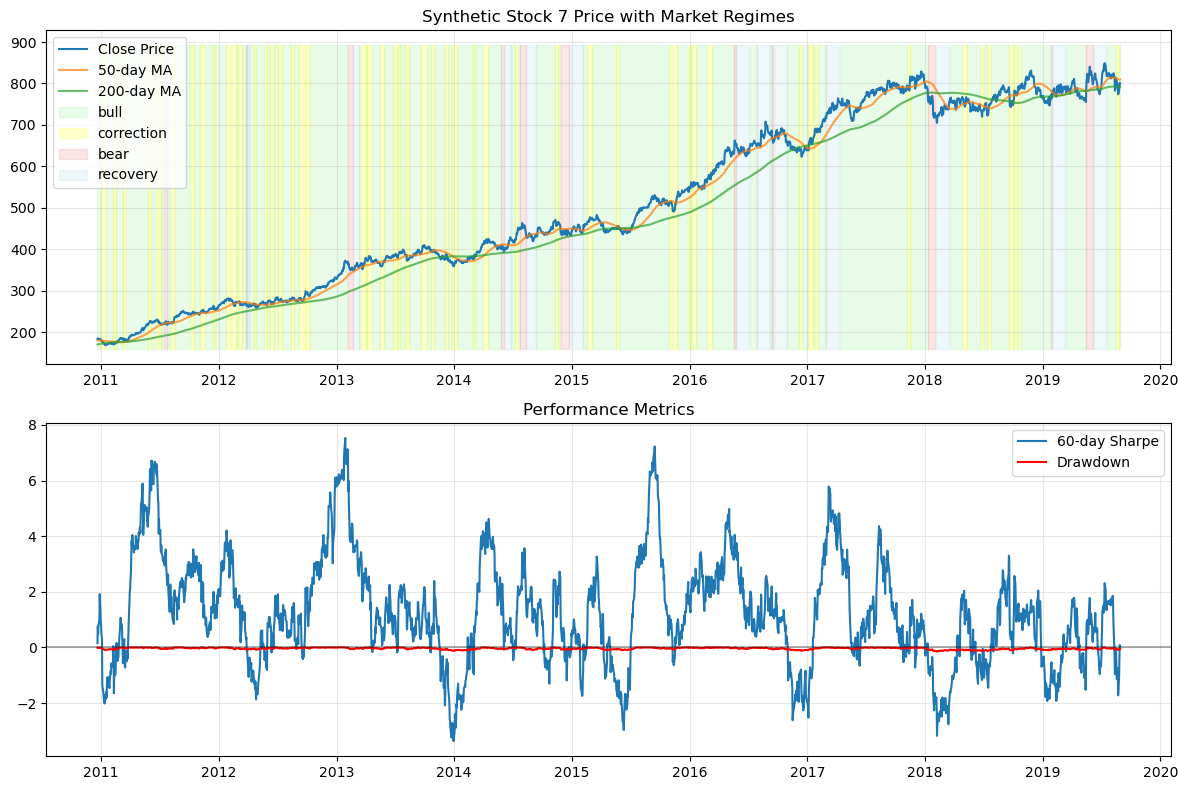

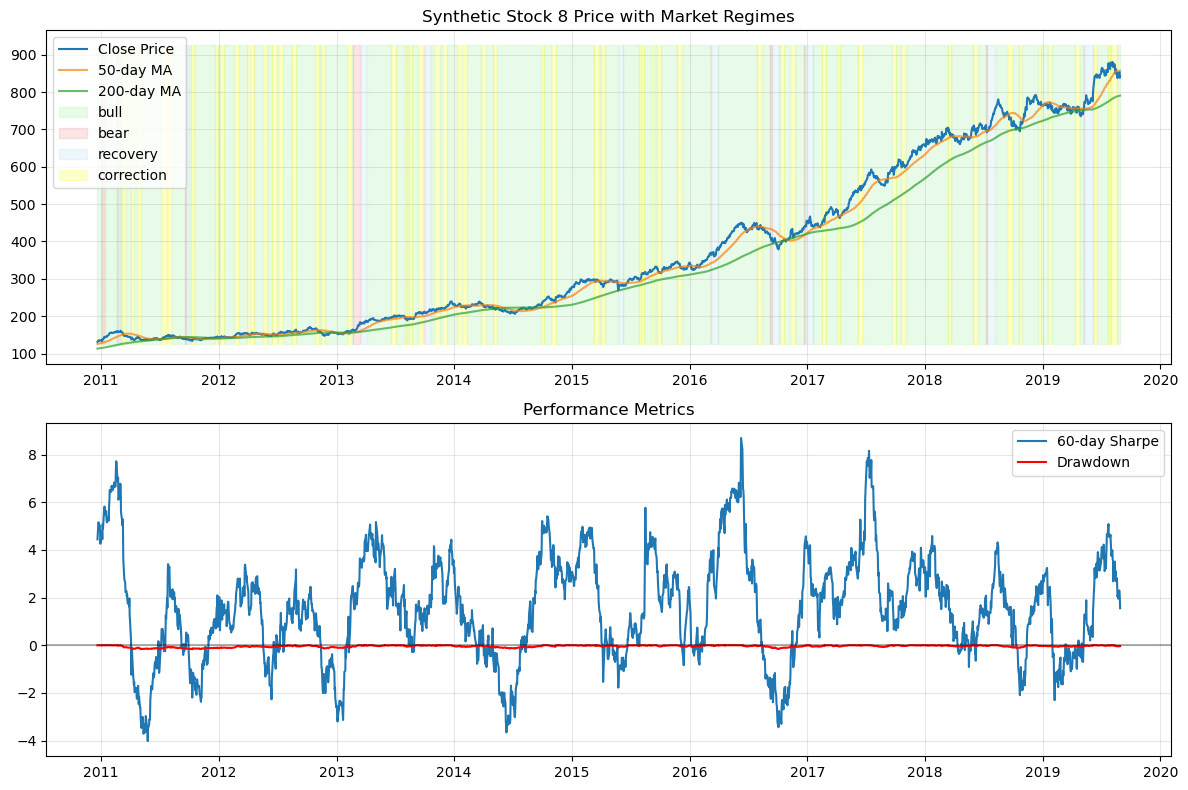

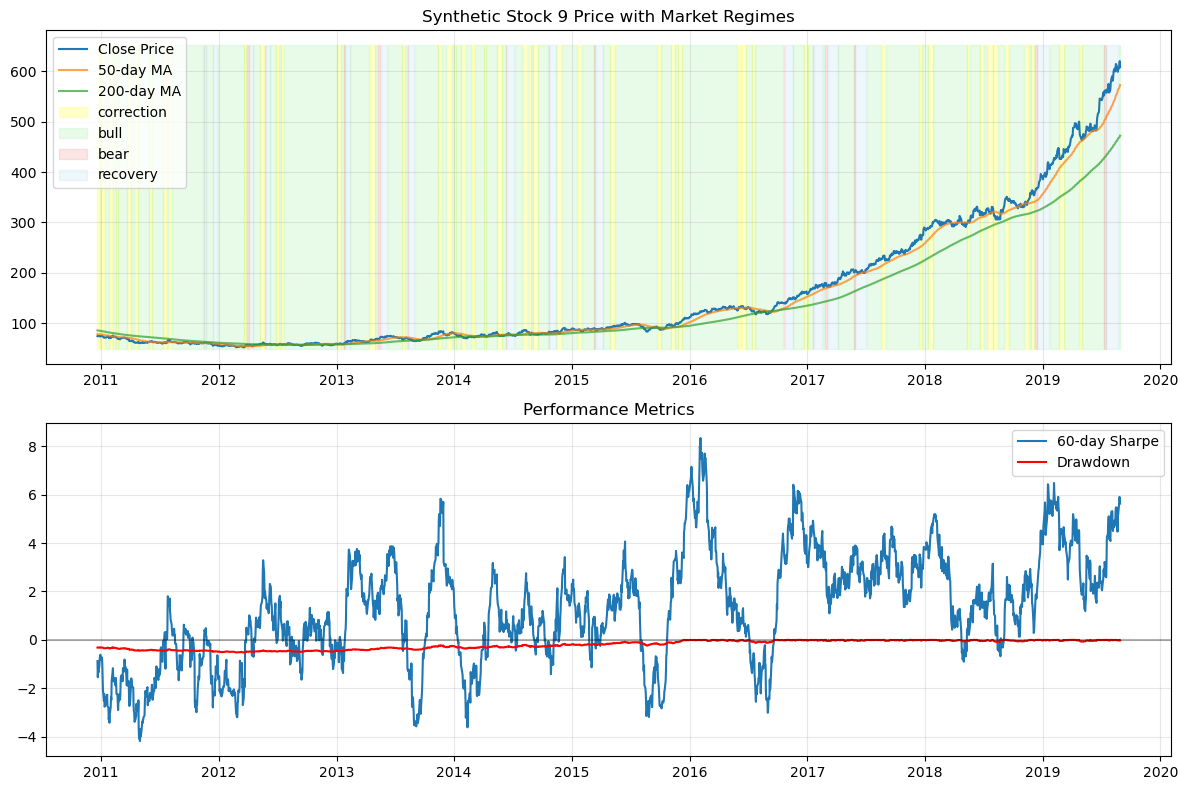

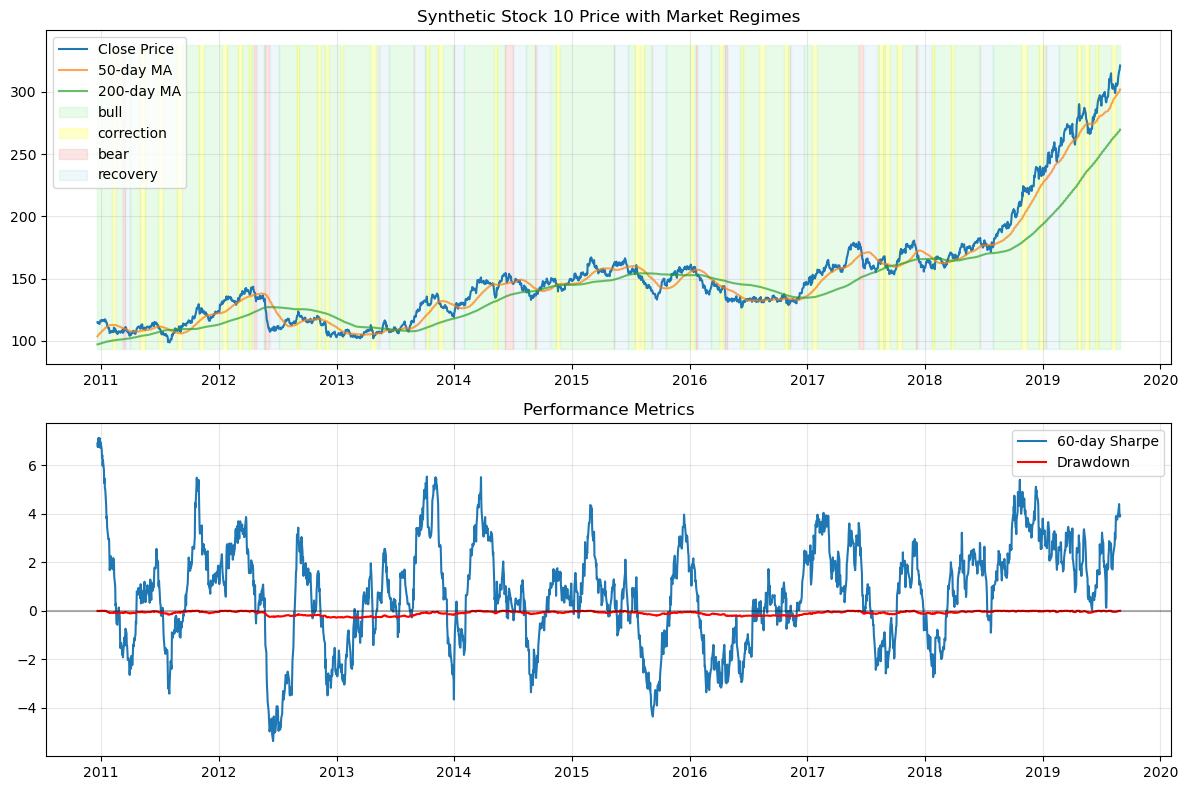

In [95]:
import numpy as np
import pandas as pd
import talib
from scipy.stats import t as student_t
import matplotlib.pyplot as plt

def generate_synthetic_data(n_stocks=5, 
                            synthetic_data_years=10, 
                            min_sharpe=0.4, 
                            min_annual_return=0.06, 
                            max_attempts=20, seed=None):
    if seed is not None:
        np.random.seed(seed)
        
    # Market regime constants
    BULL = "bull"
    BEAR = "bear"
    CORRECTION = "correction"
    CRASH = "crash"
    RECOVERY = "recovery"
    
    # Transition probabilities - adjusted for more realistic long-term trends
    regime_transitions = {
        'bull_to_bear': 0.008,      
        'bull_to_correction': 0.03,  
        'bear_to_bull': 0.15,       
        'correction_length': (5, 12),
        'correction_depth': (-0.10, -0.03),
    }
    
    synthetic_data_list = []
    
    while len(synthetic_data_list) < n_stocks:
        attempts = 0
        while attempts < max_attempts:
            attempts += 1
            
            # Stock-specific parameters with randomization
            bull_drift = np.random.normal(0.14, 0.03) 
            bear_drift = np.random.normal(-0.10, 0.02)
            upward_bias = np.random.normal(0.09, 0.02) 
            bull_vol = max(np.random.normal(0.15, 0.03), 0.02)
            bear_vol = max(np.random.normal(0.25, 0.03), 0.05)
            
            # Generate dates
            trading_days = synthetic_data_years * 252
            dates = pd.date_range(
                start=pd.Timestamp('2010-01-01'),
                periods=trading_days,
                freq='B'  # Business days
            )
            
            # Initialize arrays
            N = len(dates)
            close_prices = np.zeros(N)
            open_prices = np.zeros(N)
            high_prices = np.zeros(N)
            low_prices = np.zeros(N)
            regimes = np.array([BULL] * N, dtype=object)
            
            # Initial values
            initial_price = np.random.uniform(50, 150)
            close_prices[0] = initial_price
            open_prices[0] = initial_price * (1 + np.random.normal(0, 0.005))
            high_prices[0] = max(close_prices[0], open_prices[0]) * (1 + abs(np.random.normal(0, 0.01)))
            low_prices[0] = min(close_prices[0], open_prices[0]) * (1 - abs(np.random.normal(0, 0.01)))
            
            # Track regime state
            current_regime = BULL
            correction_target = None
            correction_end = None
            
            # Generate subsequent days
            for j in range(1, N):
                # Update regime
                r = np.random.random()
                
                if current_regime == BULL:
                    if r < regime_transitions['bull_to_bear']:
                        current_regime = BEAR
                    elif r < (regime_transitions['bull_to_bear'] + regime_transitions['bull_to_correction']):
                        current_regime = CORRECTION
                        dur = np.random.randint(*regime_transitions['correction_length'])
                        correction_end = j + dur
                        correction_target = np.random.uniform(*regime_transitions['correction_depth'])
                elif current_regime == BEAR:
                    if r < regime_transitions['bear_to_bull']:
                        current_regime = RECOVERY
                        bear_days = np.sum(regimes[:j] == BEAR)
                        correction_end = j + min(int(bear_days * 0.5), 30)  # Cap recovery period
                elif current_regime == CORRECTION:
                    if correction_end is not None and j >= correction_end:
                        current_regime = BULL
                        correction_target = None
                        correction_end = None
                elif current_regime == RECOVERY:
                    if correction_end is not None and j >= correction_end:
                        current_regime = BULL
                        correction_end = None
                elif current_regime == CRASH:
                    current_regime = RECOVERY
                    correction_end = j + 10  # Short recovery after crash
                    
                regimes[j] = current_regime
                
                # Set drift and volatility based on regime
                if current_regime == BULL:
                    drift = bull_drift
                    vol = bull_vol
                elif current_regime == BEAR:
                    drift = bear_drift
                    vol = bear_vol
                elif current_regime == CORRECTION:
                    drift = correction_target if correction_target is not None else np.random.uniform(*regime_transitions['correction_depth'])
                    vol = 0.5 * (bull_vol + bear_vol)
                elif current_regime == RECOVERY:
                    drift = bull_drift * 1.5
                    vol = bull_vol + 0.3 * (bear_vol - bull_vol)
                elif current_regime == CRASH:
                    drift = np.random.uniform(-0.15, -0.05)
                    vol = bear_vol * 2
                else:
                    drift = bull_drift
                    vol = bull_vol
                    
                # Convert annual to daily
                daily_drift = np.log(1 + drift) / 252
                daily_drift += upward_bias / 252
                daily_vol = vol / np.sqrt(252)
                
                # Generate returns with t-distribution for fat tails
                shock = student_t.rvs(df=8)
                shock /= np.sqrt(8 / (8 - 2))  # Normalize t-distribution
                
                daily_log_return = daily_drift + daily_vol * shock
                
                # Add flash crashes occasionally (reduced frequency)
                if np.random.random() < 0.00015 and current_regime not in [CRASH, CORRECTION]:
                    daily_log_return = np.random.uniform(-0.15, -0.05)
                    current_regime = CRASH
                
                # Update price
                close_prices[j] = close_prices[j-1] * np.exp(daily_log_return)
                
                # Generate OHLC
                daily_range = 0.03 if current_regime in [BEAR, CRASH] else 0.02
                range_factor = daily_vol / (bull_vol / np.sqrt(252))
                daily_range *= range_factor
                
                # Open price typically between previous close and current close
                open_frac = np.clip(np.random.normal(0.5, 0.2), 0, 1)
                open_prices[j] = close_prices[j-1] + (close_prices[j] - close_prices[j-1]) * open_frac
                
                # High/Low based on direction of move
                if close_prices[j] > close_prices[j-1]:
                    high_prices[j] = max(open_prices[j], close_prices[j]) * (1 + np.random.uniform(0, daily_range))
                    low_prices[j] = min(open_prices[j], close_prices[j]) * (1 - np.random.uniform(0, daily_range * 0.5))
                else:
                    high_prices[j] = max(open_prices[j], close_prices[j]) * (1 + np.random.uniform(0, daily_range * 0.5))
                    low_prices[j] = min(open_prices[j], close_prices[j]) * (1 - np.random.uniform(0, daily_range))
                
                # Make sure OHLC relationships are valid
                high_prices[j] = max(high_prices[j], open_prices[j], close_prices[j])
                low_prices[j] = min(low_prices[j], open_prices[j], close_prices[j])
            
            # Round price values for realism
            open_prices = np.round(open_prices, 2)
            high_prices = np.round(high_prices, 2)
            low_prices = np.round(low_prices, 2)
            close_prices = np.round(close_prices, 2)
            
            # Create DataFrame
            df = pd.DataFrame({
                'Date': dates,
                'Open': open_prices,
                'High': high_prices,
                'Low': low_prices,
                'Close': close_prices,
                'Regime': regimes
            })
            df.set_index('Date', inplace=True)
            
            # Calculate technical indicators using talib
            # Moving Averages
            df['MA5'] = talib.SMA(df['Close'].values, timeperiod=5)
            df['MA20'] = talib.SMA(df['Close'].values, timeperiod=20)
            df['MA50'] = talib.SMA(df['Close'].values, timeperiod=50)
            df['MA200'] = talib.SMA(df['Close'].values, timeperiod=200)
            
            # RSI
            df['RSI'] = talib.RSI(df['Close'].values, timeperiod=14)
            
            # Bollinger Bands
            upper, middle, lower = talib.BBANDS(df['Close'].values, timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
            df['BB_width'] = (upper - lower) / middle
            
            # ATR
            df['ATR'] = talib.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
            
            # Returns
            df['LogReturn'] = np.log(df['Close'] / df['Close'].shift(1))
            df['Return_1W'] = df['Close'].pct_change(5)
            df['Return_1M'] = df['Close'].pct_change(21)
            df['Return_3M'] = df['Close'].pct_change(63)
            
            # Drawdowns
            rolling_max = df['Close'].cummax()
            df['CurrentDrawdown'] = (df['Close'] / rolling_max) - 1
            
            # Max drawdown over rolling window
            df['MaxDrawdown_252d'] = df['CurrentDrawdown'].rolling(252).min()
            
            # Sharpe ratios
            df['Sharpe_20d'] = (df['LogReturn'].rolling(20).mean() / df['LogReturn'].rolling(20).std()) * np.sqrt(252)
            df['Sharpe_60d'] = (df['LogReturn'].rolling(60).mean() / df['LogReturn'].rolling(60).std()) * np.sqrt(252)
            df['Sharpe_252d'] = (df['LogReturn'].rolling(252).mean() / df['LogReturn'].rolling(252).std()) * np.sqrt(252)
            
            # Drop NaN values (from indicators that need lookback periods)
            df.dropna(inplace=True)
            
            # Check if this data meets our criteria for good US equities
            annual_return = (df['Close'].iloc[-1] / df['Close'].iloc[0]) ** (252 / len(df)) - 1
            overall_sharpe = (df['LogReturn'].mean() / df['LogReturn'].std()) * np.sqrt(252)
            
            # Check if data meets criteria
            if overall_sharpe >= min_sharpe and annual_return >= min_annual_return:
                # Add metadata about performance
                df.attrs['annualized_return'] = annual_return
                df.attrs['sharpe_ratio'] = overall_sharpe
                df.attrs['max_drawdown'] = df['CurrentDrawdown'].min()
                
                synthetic_data_list.append(df)
                print(f"Generated stock with Sharpe: {overall_sharpe:.2f}, Annual return: {annual_return:.2%}")
                break
                
            if attempts == max_attempts:
                print(f"Warning: Failed to generate a stock meeting criteria after {max_attempts} attempts. Relaxing constraints.")
                # If we've tried many times, relax the constraints
                min_sharpe *= 0.8
                min_annual_return *= 0.8
    
    return synthetic_data_list


def test_synthetic_data_generator():
    # Generate data with fixed parameters
    data_list = generate_synthetic_data(
        n_stocks=10, 
        synthetic_data_years=10, 
    )
    
    print(f"Generated {len(data_list)} stock datasets")
    
    # Examine and plot each dataset
    for i, df in enumerate(data_list):
        print(f"\nStock {i+1}:")
        print(f"Date range: {df.index[0]} to {df.index[-1]}")
        print(f"Annualized return: {df.attrs['annualized_return']:.2%}")
        print(f"Sharpe ratio: {df.attrs['sharpe_ratio']:.2f}")
        print(f"Maximum drawdown: {df.attrs['max_drawdown']:.2%}")
        
        # Plot price and regimes
        plt.figure(figsize=(12, 8))
        
        # Price subplot
        plt.subplot(2, 1, 1)
        plt.plot(df.index, df['Close'], label='Close Price')
        plt.plot(df.index, df['MA50'], label='50-day MA', alpha=0.7)
        plt.plot(df.index, df['MA200'], label='200-day MA', alpha=0.7)
        
        # Color regimes
        regimes = df['Regime'].unique()
        colors = {'bull': 'lightgreen', 'bear': 'lightcoral', 'correction': 'yellow', 
                  'crash': 'red', 'recovery': 'lightblue'}
        
        y_min, y_max = df['Close'].min() * 0.95, df['Close'].max() * 1.05
        for regime in regimes:
            if regime in colors:
                mask = (df['Regime'] == regime)
                if mask.any():
                    plt.fill_between(df.index, y_min, y_max, where=mask, 
                                    color=colors[regime], alpha=0.2, label=regime)
        
        plt.title(f"Synthetic Stock {i+1} Price with Market Regimes")
        plt.legend(loc='upper left')
        plt.grid(True, alpha=0.3)
        
        # Performance indicators subplot
        plt.subplot(2, 1, 2)
        plt.plot(df.index, df['Sharpe_60d'], label='60-day Sharpe')
        plt.plot(df.index, df['CurrentDrawdown'], label='Drawdown', color='red')
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.title("Performance Metrics")
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(f'synthetic_stock_{i+1}.png')
        print(f"Plot saved to 'synthetic_stock_{i+1}.png'")
    
    return data_list

# Run the test
if __name__ == "__main__":
    test_data = test_synthetic_data_generator()